In [ ]:
import os
import torch
import pickle 
import numpy as np 
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms 
import torchvision.models as models
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.datasets as datasets
import requests

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Image Captioning

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we extract meaningful features regarding the image that would help us describe it. Second, we generate a sequence of words that best fit those features.
we will do it by using CNN architecture and connect it directly to a LSTM network with an appropriate attention mechanism to appropriately weight the feature maps.

I am using the Flickr8k dataset from <a href="https://www.kaggle.com/adityajn105/flickr8k/activity">here</a> .



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks2/HW5/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [ ]:
import pandas as pd
import spacy

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

data_location = "/content"

In [ ]:
class vocab:
  def __init__ (self):
    self.idx_to_word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>"}
    self.word_to_idx = self.word_to_idx = {s:i for i,s in self.idx_to_word.items()}
    self.spacy_eng = spacy.load("en")

  def __len__(self):
    return len(self.idx_to_word)


  def to_tokens(self, text):
    return [token.text.lower() for token in self.spacy_eng.tokenizer(text)]


  def creat_vocab(self, text_list):
    idx = len(self.idx_to_word)
    
    for text in text_list:
      text_words = self.to_tokens(text)
      for word in text_words:
        
        if word in self.word_to_idx:
          continue
        else:
          self.word_to_idx[word] = idx
          self.idx_to_word[idx] = word
          idx += 1



In [ ]:


class img_cap_dataset(Dataset):

    def __init__(self,images_dir,captions,transform=None):
        
        
        self.vocab = vocab()
        self.df = pd.read_csv(captions)
        self.images = self.df["image"]
        self.captions = self.df["caption"]
        self.transform = transform
        self.images_dir = images_dir
        self.vocab.creat_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.images[idx]
        img_location = os.path.join(self.images_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)

        
        start = torch.tensor([self.vocab.word_to_idx["<SOS>"]])
        mid = torch.tensor([self.fit_text(caption)]).view(-1)
        end = torch.tensor([self.vocab.word_to_idx["<EOS>"]])
        caption_ids = torch.cat((start,mid,end))


        return img, caption_ids


    def fit_text(self,text):
        tokens = self.vocab.to_tokens(text)
        return [self.vocab.word_to_idx[token] for token in tokens]  

In [ ]:
#normalization values
mean = (0.485, 0.456, 0.406)
var = (0.229, 0.224, 0.225)



transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, var)
    
])

In [ ]:
def show_image(img,mean=mean,var=var, title=None):
    
    #unnormalize 
    for i in range(3):
      img[i] = img[i] * var[i] + mean[i]

    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    
    if title is not None:
        plt.title(title)
        
    plt.show()

In [ ]:
#creating the dataset
dataset =  img_cap_dataset(
    images_dir = data_location + "/Images",
    captions = data_location + "/captions.txt",
    transform=transformer
)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
class collate_fn:
    def __init__(self,padding_idx,batch_first):
        self.padding_idx = padding_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        target_captions = [data[1] for data in batch]
        target_captions = pad_sequence(target_captions, batch_first=self.batch_first, padding_value=self.padding_idx)
        images = [data[0].unsqueeze(0) for data in batch]
        images = torch.cat(images,dim=0)
        
        return images,target_captions

In [ ]:
#creating the Data Loader
NUM_WORKER = 2
BATCH_SIZE = 64

padding_idx = dataset.vocab.word_to_idx["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=collate_fn(padding_idx=padding_idx,batch_first=True)
)


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        res_modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*res_modules)
        

    def forward(self, images):
        features = self.resnet(images)                                   
        features = features.permute(0, 2, 3, 1)                           
        features = features.view(features.size(0), -1, features.size(-1)) 
        return features

In [ ]:
class Decoder_Attention_LSTM(nn.Module):
    def __init__(self, embed_size, vocab, encoder_dim, decoder_dim):
        super().__init__()

        self.vocab = vocab
        self.vocab_size = len(self.vocab)
        self.decoder_dim = decoder_dim
        self.NUM_att_HEADS = 4
        self.LSTM_NUM_LAYERS = 1
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        self.embedding = nn.Embedding(self.vocab_size,embed_size)
        self.h_to_query = nn.Linear(decoder_dim,encoder_dim)
        self.attention = nn.MultiheadAttention(encoder_dim, self.NUM_att_HEADS, batch_first=False)
        self.lstm = nn.LSTM(embed_size+encoder_dim,decoder_dim,bias=True, batch_first=False, num_layers = self.LSTM_NUM_LAYERS)
        self.drop = nn.Dropout(0.25)
        self.fc = nn.Linear(decoder_dim,self.vocab_size//2)
        self.fc2 = nn.Linear(self.vocab_size//2,self.vocab_size)

    
    def forward(self,captions, features):
        
        embeds = self.embedding(captions)
        #first hidden state
        h, c = self.init_hidden_state(features)
        
        seq_len = len(captions[0])-1
        features = features.permute(1, 0, 2)
        predictions = torch.zeros(captions.size(0), seq_len, self.vocab_size).to(device)
                
        for word in range(seq_len):
            #attention
            q = self.h_to_query(h)
            context, _ = self.attention(q, features, features)
            #lstm
            input = torch.cat((embeds[:, word], context.squeeze(0)), dim=1).unsqueeze(0)
            h_out , (h, c) = self.lstm(input, (h, c))
            #output
            out = self.fc(self.drop(h_out.squeeze(0)))
            out = self.fc2(F.relu(out))
            predictions[:,word] = out

        return predictions
    
    def predict_next_word(self, current_hidden_state, word, features):

            word_idx = torch.tensor(self.vocab.word_to_idx[word]).view(1,-1).to(device)
            embeds = self.embedding(word_idx)

            # attenstion
            h = current_hidden_state[0]
            q = self.h_to_query(h)
            context, _ = self.attention(q, features, features)

            #lstm 
            input = torch.cat((embeds[:, 0], context.squeeze(0)), dim=1).unsqueeze(0)
            h_out , (h, c) = self.lstm(input, current_hidden_state)
            next_hidden_state = (h, c)

            # output predicted word
            out = self.fc(self.drop(h_out.squeeze(0)))
            out = self.fc2(F.relu(out))
            out = out.view(features.size(1),-1)
            prediction_idx = out.argmax(dim=1)
            pred_word = self.vocab.idx_to_word[prediction_idx.item()]
            
            return pred_word, next_hidden_state


    def generate_caption(self,features,max_len):

        start_word = '<SOS>'
        h, c = self.init_hidden_state(features)
        features = features.permute(1, 0, 2)
        captions = []
        current_word = start_word

        for word in range(max_len):

            #predict next word
            pred_word, (h,c) = self.predict_next_word((h, c), current_word, features)
            #break when <EOS>
            if pred_word == "<EOS>":
                break
            #next word + append predicted word to total caption
            captions.append(pred_word)
            current_word = pred_word
            
        return captions
    
    
    def init_hidden_state(self, features):
        mean_features = features.mean(dim=1)
        h = self.init_h(mean_features)
        c = self.init_c(mean_features)
        (h, c) = h.unsqueeze(0), c.unsqueeze(0)
        return h, c

In [ ]:
class Image2Cap_model(nn.Module):
    def __init__(self,embed_size, vocab, encoder_dim, decoder_dim):
        super().__init__()
        self.vocab = vocab
        self.encoder = Encoder()
        self.decoder = Decoder_Attention_LSTM(embed_size=embed_size, vocab = vocab, encoder_dim=encoder_dim, decoder_dim=decoder_dim)
        
    def forward(self, captions, images):
        features = self.encoder(images)
        out = self.decoder(captions, features)
        
        return out

    def generate_caption(self, img, max_len=20):
      features = model.encoder(img[0:1].to(device))
      captions = self.decoder.generate_caption(features, max_len)
      pred_caption = ' '.join(captions)

      return pred_caption

In [ ]:
embed_size=1024
vocab_size = len(dataset.vocab)
encoder_dim= 2048
decoder_dim= 1024
lr = 0.0003

In [ ]:
model = Image2Cap_model(
    embed_size=embed_size,
    vocab = dataset.vocab,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

padding_idx = dataset.vocab.word_to_idx["<PAD>"]
criterion = nn.CrossEntropyLoss(ignore_index = padding_idx)

In [ ]:
num_epochs = 25
train_loss_history = []
train_acc_history = []

for epoch in range(1,num_epochs+1):   
    running_loss = 0.0
    running_acc = 0.0
    total_num_words = 0

    for i, (image, captions) in enumerate(iter(data_loader)):
        image, captions = image.to(device),captions.to(device)
        
        pred = model(captions, image)

        # Loss calc
        targets = captions[:,1:].reshape(-1)
        pred = pred.view(-1, vocab_size)
        argmax_pred = pred.argmax(dim=1)
        running_acc += (argmax_pred == targets).sum()
        loss = criterion(pred, targets)
        total_num_words += argmax_pred.size()[0]
        #backward + optimitzer step + zero grads
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print('Epoch: {} Loss: {:.4f}  |  Acc: {:.4f} '.format(epoch, running_loss/len(dataset), running_acc/total_num_words))
    train_loss_history.append(running_loss / len(dataset))
    train_acc_history.append(running_acc/total_num_words)
        

Epoch: 1 Loss: 0.0573  |  Acc: 0.1853 
Epoch: 2 Loss: 0.0434  |  Acc: 0.2257 
Epoch: 3 Loss: 0.0383  |  Acc: 0.2410 
Epoch: 4 Loss: 0.0346  |  Acc: 0.2520 
Epoch: 5 Loss: 0.0315  |  Acc: 0.2644 
Epoch: 6 Loss: 0.0290  |  Acc: 0.2770 
Epoch: 7 Loss: 0.0261  |  Acc: 0.2935 
Epoch: 8 Loss: 0.0238  |  Acc: 0.3087 
Epoch: 9 Loss: 0.0218  |  Acc: 0.3222 
Epoch: 10 Loss: 0.0200  |  Acc: 0.3356 
Epoch: 11 Loss: 0.0187  |  Acc: 0.3442 
Epoch: 12 Loss: 0.0175  |  Acc: 0.3544 
Epoch: 13 Loss: 0.0165  |  Acc: 0.3614 
Epoch: 14 Loss: 0.0153  |  Acc: 0.3722 
Epoch: 15 Loss: 0.0144  |  Acc: 0.3798 
Epoch: 16 Loss: 0.0137  |  Acc: 0.3850 
Epoch: 17 Loss: 0.0133  |  Acc: 0.3885 
Epoch: 18 Loss: 0.0151  |  Acc: 0.3725 
Epoch: 19 Loss: 0.0144  |  Acc: 0.3794 
Epoch: 20 Loss: 0.0122  |  Acc: 0.3974 
Epoch: 21 Loss: 0.0127  |  Acc: 0.3948 
Epoch: 22 Loss: 0.0111  |  Acc: 0.4094 
Epoch: 23 Loss: 0.0103  |  Acc: 0.4147 
Epoch: 24 Loss: 0.0129  |  Acc: 0.3905 
Epoch: 25 Loss: 0.0113  |  Acc: 0.4076 


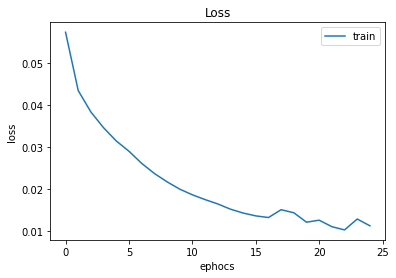

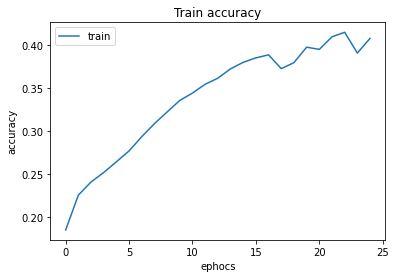

In [ ]:
#plotting train loss and train acc

plt.plot(range(len(train_loss_history)), train_loss_history)
plt.legend(['train'])
plt.title("Loss")
plt.xlabel("ephocs")
plt.ylabel("loss")
plt.show()

plt.plot(range(len(train_acc_history)), train_acc_history)
plt.legend(['train'])
plt.title("Train accuracy")
plt.xlabel("ephocs")
plt.ylabel("accuracy")
plt.show()

In [ ]:

def creat_Ception(img, model, max_len):
  model.eval()
  with torch.no_grad():
      pred_caption = model.generate_caption(img, max_len)
      show_image(img[0],title=pred_caption)


GROUND TRUTH CAPTION: a black and white dog runs through pole obstacles . 
PREDICTION:


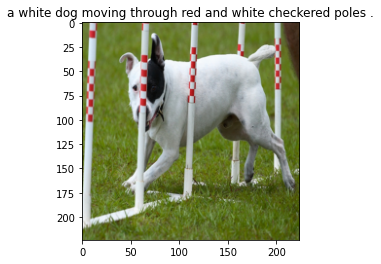

GROUND TRUTH CAPTION: a brown dog is laying on his side on a beige carpet , with a green object in the foreground . 
PREDICTION:


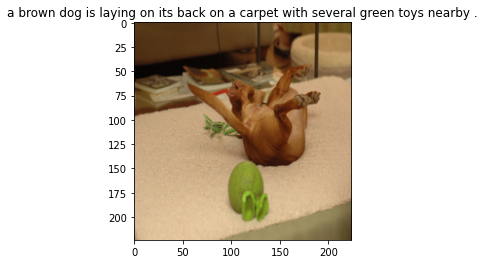

GROUND TRUTH CAPTION: a small airplane flying through the air with lots of smoke coming out of the plane . 
PREDICTION:


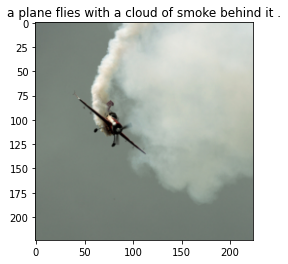

GROUND TRUTH CAPTION: skiiers race in the snow . 
PREDICTION:


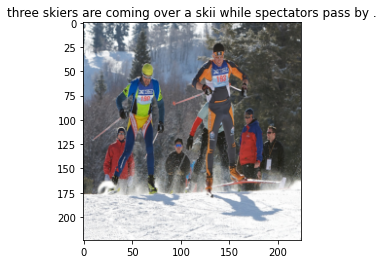

GROUND TRUTH CAPTION: a little boy and a little girl are playing with pebbles on the beach . 
PREDICTION:


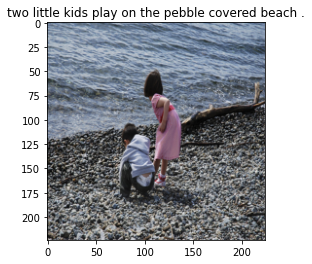

GROUND TRUTH CAPTION: blonde young boy rides a zip line in the woods . 
PREDICTION:


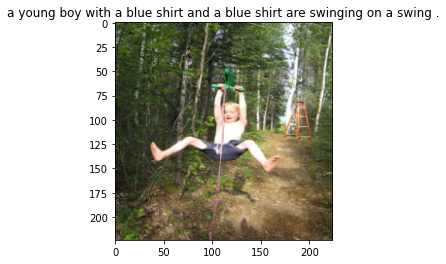

GROUND TRUTH CAPTION: the skateboarder wearing jeans and a white shirt performs a trick . 
PREDICTION:


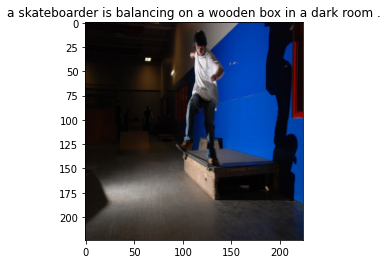

GROUND TRUTH CAPTION: an individual in a red suit doing a ski jump . 
PREDICTION:


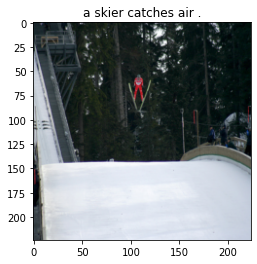

GROUND TRUTH CAPTION: two men in two canoes are sitting in a lake . 
PREDICTION:


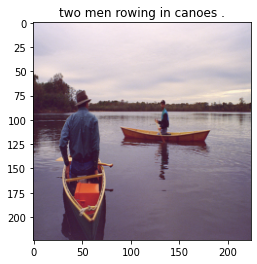

GROUND TRUTH CAPTION: a group of foreign people stand with umbrellas on the side of the street . 
PREDICTION:


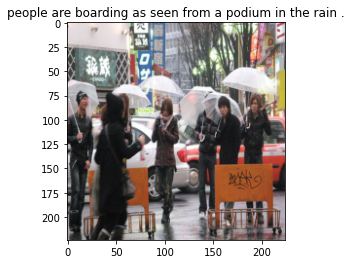

GROUND TRUTH CAPTION: an old man walking a ferrett through the street on a leash . 
PREDICTION:


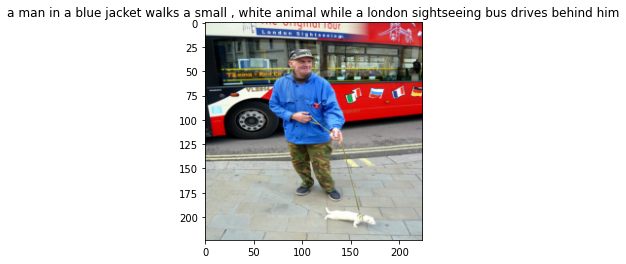

GROUND TRUTH CAPTION: the young redheaded girl plays on the teeter totter . 
PREDICTION:


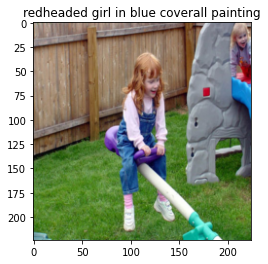

GROUND TRUTH CAPTION: a muzzled greyhound dog is running around a track . 
PREDICTION:


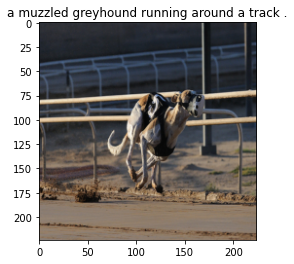

GROUND TRUTH CAPTION: the man with no shirt and flip flops looks at the women in white shorts . 
PREDICTION:


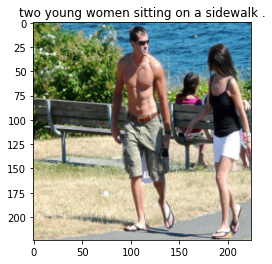

GROUND TRUTH CAPTION: a girl and boy look at each other . 
PREDICTION:


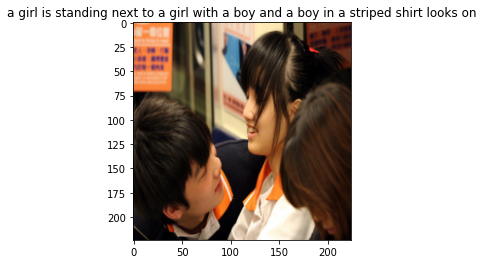

GROUND TRUTH CAPTION: a couple walking down the street . 
PREDICTION:


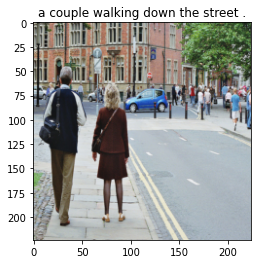

GROUND TRUTH CAPTION: a crowd of children in white shirts , black shorts and white hats jumping rope . 
PREDICTION:


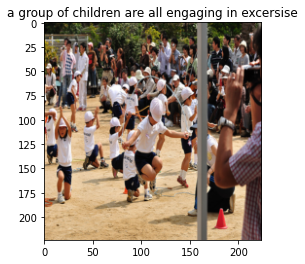

GROUND TRUTH CAPTION: a boy tosses a rock across a river . 
PREDICTION:


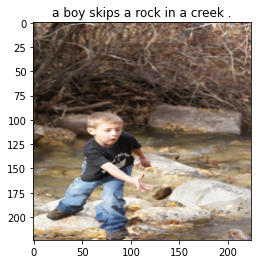

GROUND TRUTH CAPTION: a girl wears a sign that says " free hugs " . 
PREDICTION:


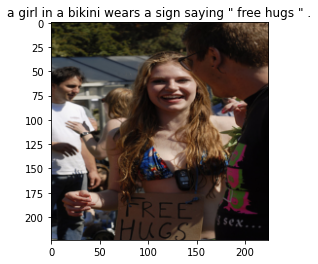

GROUND TRUTH CAPTION: someone is splashing through ankle - high sun - lit water . 
PREDICTION:


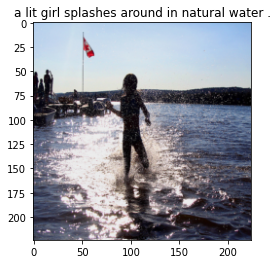

GROUND TRUTH CAPTION: a light brown dog running through an obstacle course . 
PREDICTION:


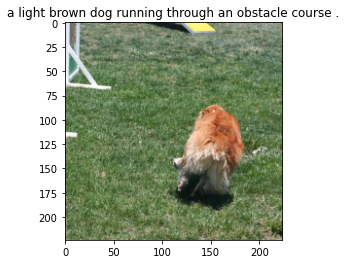

GROUND TRUTH CAPTION: a man wearing a beret rides his bicycle on a recreation trail . 
PREDICTION:


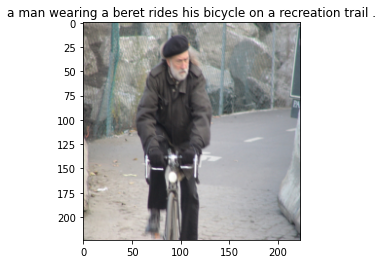

GROUND TRUTH CAPTION: a man wearing skis and a parachute in midair 
PREDICTION:


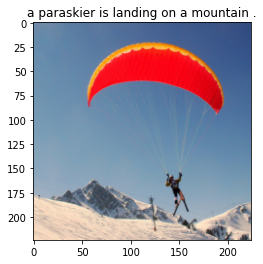

GROUND TRUTH CAPTION: two black dogs are playing in a grass . 
PREDICTION:


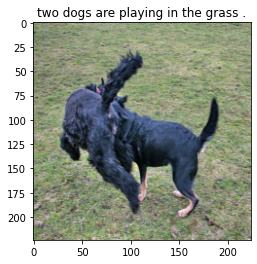

GROUND TRUTH CAPTION: the dog is happily running on the beach . 
PREDICTION:


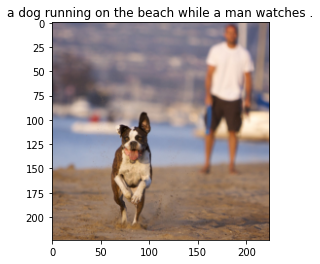

GROUND TRUTH CAPTION: some dogs are running on a deserted beach . 
PREDICTION:


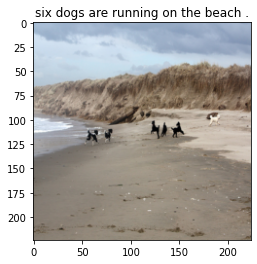

GROUND TRUTH CAPTION: a man is taking a shower . 
PREDICTION:


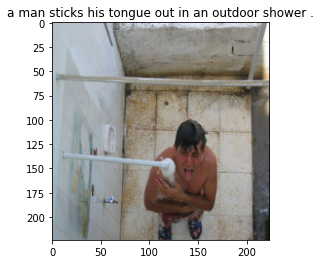

GROUND TRUTH CAPTION: a child on a swing . 
PREDICTION:


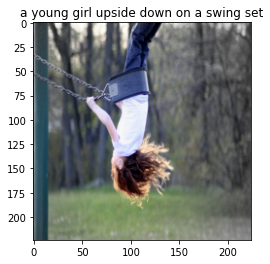

GROUND TRUTH CAPTION: a line of green and red dune buggys on a gravel road near rocks and large pine trees . 
PREDICTION:


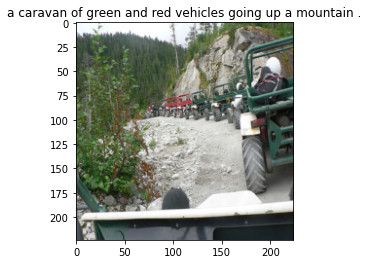

GROUND TRUTH CAPTION: two men ride horses and a calf runs between them . 
PREDICTION:


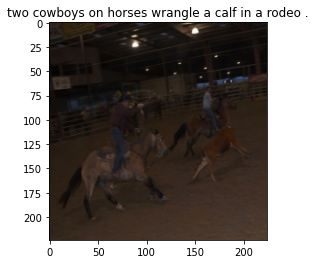

In [ ]:
# show example of some image captions

for i, (img, gt_caption) in enumerate(iter(data_loader)):
  if i >= 30:
    break
    
  real_caption = ""
  for idx in gt_caption[0][1:].tolist():
    if idx == dataset.vocab.word_to_idx["<EOS>"]:
      break

    real_caption +=dataset.vocab.idx_to_word[idx] + " "

  print(f"GROUND TRUTH CAPTION: {real_caption}")
  print("PREDICTION:")
  creat_Ception(img[0:1],model,20)
  
